# Geothermal energy extraction
Here I solve the equations for nonisothermal flow in porous media. The equations will be solved with different assumptions:
  + Viscosity does not change with temperature
  + Viscosity is a function of temperature
  
The domains are:
  + 1D linear
  + 1D radial
  + 2D
  + 3D

## Start the toolbox

In [1]:
% start the FVTool
cd('/home/ali/MyPackages/FVTool/');
FVToolStartUp()

AGMG 3.x linear solver is NOT available.
FiniteVolumeToolbox has started successfully.


## Define the functions

In [2]:
function p_val=continuity(m, q)
mu_val=1e-3; % (Pa.s)
poros=0.2;
perm_val=1.0e-12; % (m^2)
% physical system
p_out=250e5; % (Pa)
% assign values to the domain
k=createCellVariable(m, perm_val);
labda_face=harmonicMean(k/mu_val);
phi=createCellVariable(m,poros);
% Define the boundaries
BCp = createBC(m); % Neumann BC for pressure
BCc = createBC(m); % Neumann BC for concentration
% change the right boandary to constant pressure (Dirichlet)
BCp.right.a(:)=0.0;
BCp.right.b(:)=1.0;
BCp.right.c(:)=p_out;
% left boundary
BCp.left.a(:)=0.0;
BCp.left.b(:)=1.0;
BCp.left.c(:)=p_out;
Mdiffp=diffusionTerm(-labda_face);
[Mbcp, RHSbcp] = boundaryCondition(BCp);
RHSsp=constantSourceTerm(q);
Mp= Mdiffp+Mbcp;
RHSp=RHSsp+RHSbcp;
p_val=solvePDE(m, Mp, RHSp);
end

function T=geotherm_iso(m, p, qin, qout)
labda_s=2.6; % W/(m.K)
labda_w=0.6; % W/(m.K)
rho_w=1000; % kg/m^3
rho_s=2650; % kg/m^3
cp_w=4184; % J/(kg.K)
cp_s=900; % J/(kg.K)
poros=0.2;
perm=1e-12; % m^2
mu_w=1e-3; % Pa.s
a=poros*rho_w*cp_w+(1-poros)*rho_s*cp_s;
labda=createCellVariable(m,labda_w^poros*labda_s^(1-poros));
T_init=80+273.15; % K
T_inj=40+273.15;  % K
T_0=25+273.15;
BC=createBC(m);
BC.left.a(:)=0.0;
BC.left.b(:)=1.0;
BC.left.c(:)=T_init;
BC.right.a(:)=0.0;
BC.right.b(:)=1.0;
BC.right.c(:)=T_init;
[Mbc,RHSbc]=boundaryCondition(BC);
T0=createCellVariable(m, T_init, BC)
u=-perm/mu_w*gradientTerm(p); % m/s
Mconv=convectionUpwindTerm(rho_w*cp_w*u);
RHSconv=divergenceTerm(rho_w*cp_w*T_0*u);
Mcond=diffusionTerm(harmonicMean(labda));
RHSs1=constantSourceTerm(rho_w*cp_w*(T_inj-T_0)*qin);
Ms=linearSourceTerm(-rho_w*cp_w*qout);
RHSs2=constantSourceTerm(-rho_w*cp_w*T_0*qout);
dt=100*24*3600; % s
t_final=40*dt;
for t=dt:dt:t_final
    [Mt, RHSt]=transientTerm(T0, dt, a);
    M=Mt+Mconv-Mcond+Mbc+Ms;
    RHS=RHSbc+RHSt+RHSs1+RHSs2+RHSconv;
    T=solvePDE(m, M, RHS);
    T0=T;
end
end

## 2D domain

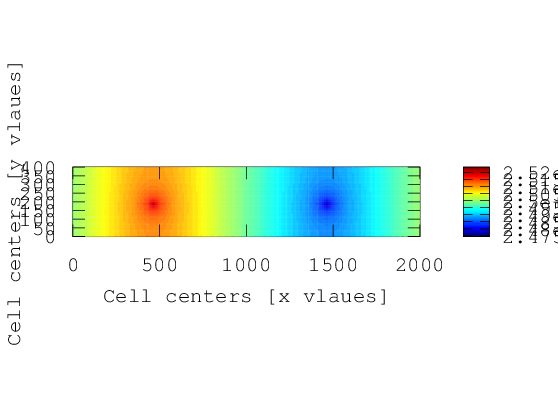

In [5]:
Nx=100;
Ny=50;
Nz=1;
Lx=2000;
Ly=500;
Lz=100;
v_cell=(Lx*Ly*Lz)/(Nx*Ny*Nz)
q_in=100/3600; %[m^3/s]
m=createMesh2D(Nx,Ny, 2000, 400);
q=createCellVariable(m, 0.0);
qin=q;
qout=q;
q.value(25,25)=q_in/v_cell;
qin.value(25,25)=q_in/v_cell;
q.value(75,25)=-q_in/v_cell;
qout.value(75,25)=-q_in/v_cell;
p=continuity(m, q);
visualizeCells(p)
shading interp

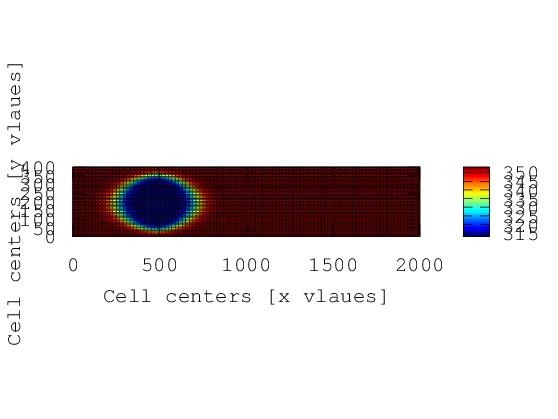

In [6]:
T=geotherm_iso(m, p, qin, qout)
visualizeCells(T)
%T.value

## 1D domain

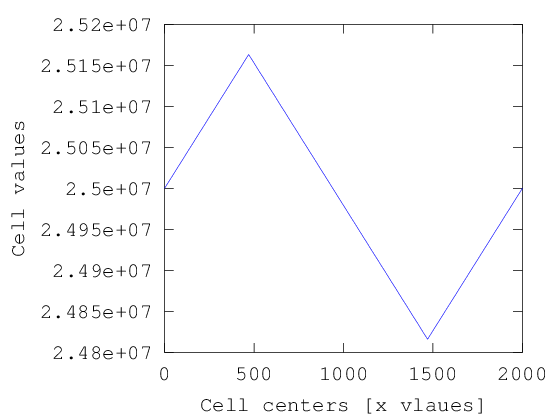

In [36]:
Nx=100;
Ny=1;
Nz=1;
Lx=2000;
Ly=400;
Lz=100;
v_cell=(Lx*Ly*Lz)/(Nx*Ny*Nz)
q_in=100/3600; %[m^3/s]
m=createMesh1D(Nx, Lx);
q=createCellVariable(m, 0.0);
qin=q;
qout=q;
q.value(25)=q_in/v_cell;
qin.value(25)=q_in/v_cell;
q.value(75)=-q_in/v_cell;
qout.value(75)=-q_in/v_cell;
p=continuity(m, q);
visualizeCells(p)

## 3D domain

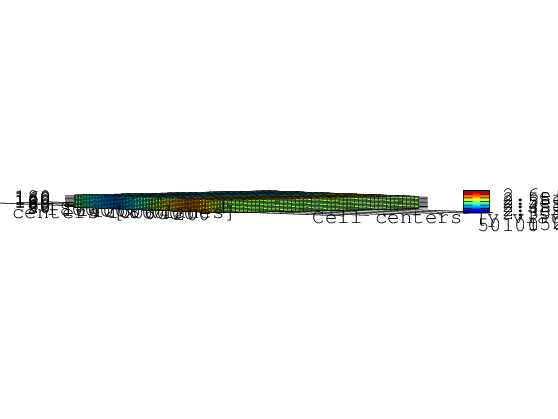

In [37]:
Nx=100;
Ny=50;
Nz=10;
Lx=2000;
Ly=400;
Lz=200;
v_cell=(Lx*Ly*Lz)/(Nx*Ny*Nz)
q_in=100/3600; %[m^3/s]
m=createMesh3D(Nx,Ny,Nz, Lx, Ly, Lz);
q=createCellVariable(m, 0.0);
qin=q;
qout=q;
q.value(25,25,:)=q_in/v_cell;
qin.value(25,25,:)=q_in/v_cell;
q.value(75,25,:)=-q_in/v_cell;
qout.value(75,25,:)=-q_in/v_cell;
p=continuity(m, q);
visualizeCells(p)
%shading interp